# Using a multi-layer LSTM for forecasting

## Importing

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

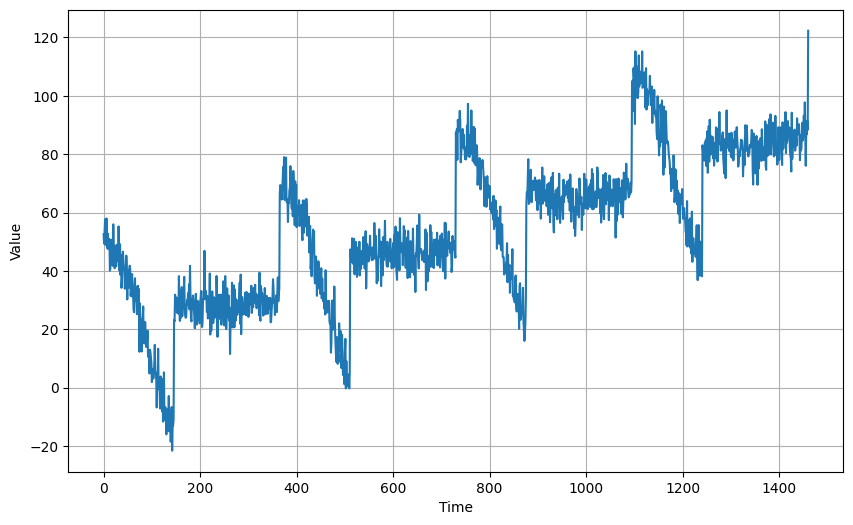

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [9]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

# Tune the Learning Rate

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 55.0750 - learning_rate: 1.0000e-08
Epoch 2/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 55.2289

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 55.2640 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 52.7829 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 50.9101 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 48.9151 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 46.4020 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 41.6539 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 32.3240 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24.0016 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20.6363 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 17.4610 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/st

(1e-08, 0.001, 0.0, 30.0)

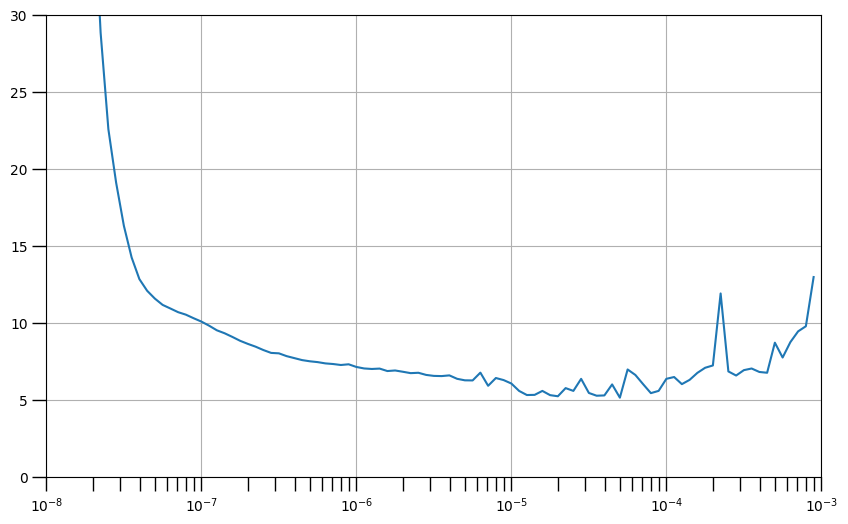

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 34.9375 - mae: 35.4679
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 12.5086 - mae: 13.0104
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.0584 - mae: 8.5474
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6535 - mae: 7.1361
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3285 - mae: 6.8149
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2793 - mae: 6.7635
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1914 - mae: 6.6744
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7426 - mae: 6.2276
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3590 - mae: 5.8472
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6455 - mae: 6.1316
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4250 - mae: 5.9086
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8873 - mae: 5.3642
Epoch 13/100
31/31 ━━

## Model Prediction

In [13]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


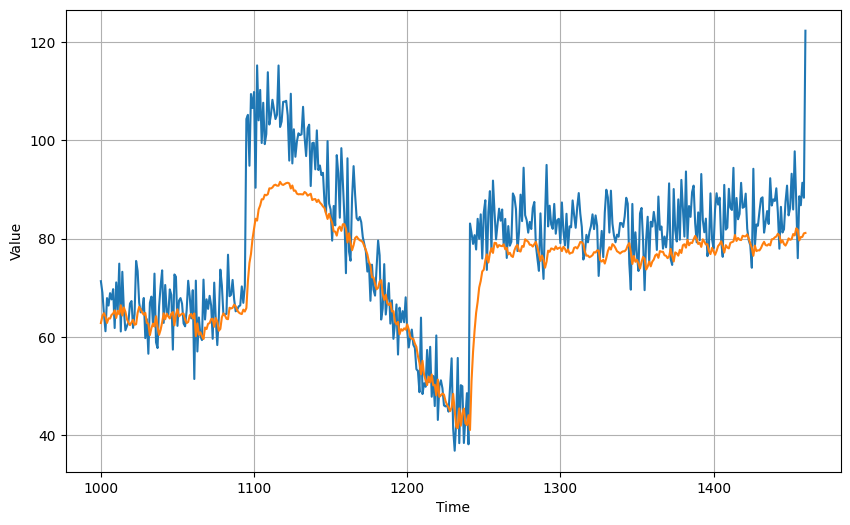

In [14]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [15]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

86.19966
6.8951955


## Optional: Including a Validation Set while Training

In [16]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 84.4103 - mae: 85.0088 - val_loss: 42.2803 - val_mae: 45.8697
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 16.1619 - mae: 16.6780 - val_loss: 27.4203 - val_mae: 29.8392
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 13.3767 - mae: 13.8810 - val_loss: 22.9219 - val_mae: 25.0759
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 10.2247 - mae: 10.7244 - val_loss: 19.0962 - val_mae: 21.0044
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.6865 - mae: 9.1744 - val_loss: 16.9070 - val_mae: 18.6486
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.9940 - mae: 9.4869 - val_loss: 15.4212 - val_mae: 17.0197
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6773 - mae: 9.1712 - val_loss: 16.1748 - val_mae: 17.8334
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.4001 - mae: 7.8860 - val_loss: 11.7765 - val_mae: 13.0870
Epoch 9/100
31/31 ━━━━━━━━━━━━━━